# LSTM-Based Stock Price Forecasting Using 100 S&P 500 Companies with a 20-Day Sliding Window (2010–2021)


Step 1 — Setup and Configuration

This step defines the overall project structure, sets random seeds for reproducibility, and specifies key parameters such as the lookback window, target horizon, and feature schema. It also creates directories for raw data, engineered features, model artifacts, and evaluation outputs.

In [1]:
import os, sys, json, random, warnings
from pathlib import Path
import numpy as np, pandas as pd
warnings.filterwarnings("ignore")

SEED=42
random.seed(SEED); np.random.seed(SEED); os.environ["PYTHONHASHSEED"]=str(SEED)

PROJECT_DIR = Path("/Users/arvindshine/stock-price-forecasting/LSTM_stock_fresh")
DATA_DIR    = PROJECT_DIR / "data"
RAW_DIR     = DATA_DIR / "raw"
FEAT_DIR    = DATA_DIR / "features"
ARTIFACTS   = PROJECT_DIR / "artifacts"
EVAL_DIR    = PROJECT_DIR / "eval"

TICKERS_FILE = PROJECT_DIR / "tickers.txt"
assert TICKERS_FILE.exists(), f"Missing {TICKERS_FILE}. Copy it from your LightGBM folder."
TICKERS = [t.strip() for t in TICKERS_FILE.read_text().splitlines() if t.strip()]

START_DATE="2010-01-01"; END_DATE="2021-12-31"; FREQ="1D"
SPOTLIGHT_TICKER="GOOGL"
LOOKBACK=20; HORIZON=1
TARGET_NAME="target_ret_t+1"
PERDAY=["Open","High","Low","Close","Volume","log_volume","day_of_week","MA20","RSI14"]
F=len(PERDAY)

TRAIN_FRAC=0.80
VAL_FRAC_WITHIN_T=0.20

RAW_PATH  = RAW_DIR  / "raw_prices.parquet"
FEAT_PATH = FEAT_DIR / "features.parquet"
WIN_META  = FEAT_DIR / "windows_meta.parquet"

X_SCALER_PATH = ARTIFACTS / "x_scaler.pkl"
LSTM_PATH     = ARTIFACTS / "lstm_multistock.keras"

print(json.dumps({
    "python": sys.version.split()[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
}, indent=2))
print(f"Project: {PROJECT_DIR}")
print(f"Tickers: {len(TICKERS)} | GOOGL in file? {'GOOGL' in TICKERS}")
print(f"Dates: {START_DATE} → {END_DATE} | Lookback={LOOKBACK}")
print(f"Per-day features ({F}): {PERDAY}")


{
  "python": "3.9.6",
  "numpy": "1.26.4",
  "pandas": "1.5.3"
}
Project: /Users/arvindshine/stock-price-forecasting/LSTM_stock_fresh
Tickers: 101 | GOOGL in file? True
Dates: 2010-01-01 → 2021-12-31 | Lookback=20
Per-day features (9): ['Open', 'High', 'Low', 'Close', 'Volume', 'log_volume', 'day_of_week', 'MA20', 'RSI14']


Step 2 — Data Download and Normalisation

This step retrieves daily OHLCV data for the selected stock universe using Yahoo Finance. MultiIndex columns are flattened, duplicate names are removed, and all numeric fields are coerced into consistent types. Missing tickers are logged, and GOOGL is explicitly included, with fallback to GOOG if required. The cleaned dataset is then saved in parquet format.

In [2]:
import yfinance as yf, time

def fetch_one(ticker, start=START_DATE, end=END_DATE, tries=3, sleep=1.0):
    for _ in range(tries):
        df = yf.download(
            ticker, start=start, end=end,
            auto_adjust=False, progress=False, group_by="column"
        )
        if df is not None and not df.empty:
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            df = df.loc[:, ~pd.Index(df.columns).duplicated(keep="first")]
            df = df.reset_index()
            df["symbol"] = ticker
            if "Adj Close" not in df.columns and "Close" in df.columns:
                df["Adj Close"] = df["Close"]
            return df
        time.sleep(sleep)
    return None

def _coerce_1d(col):
    if isinstance(col, pd.DataFrame):
        col = col.iloc[:,0]
    return pd.to_numeric(col, errors="coerce")

def normalize_frame(df):
    needed = ["Date","Open","High","Low","Close","Adj Close","Volume","symbol"]
    for c in needed:
        if c not in df.columns:
            df[c] = np.nan
    df["Open"]  = _coerce_1d(df["Open"])
    df["High"]  = _coerce_1d(df["High"])
    df["Low"]   = _coerce_1d(df["Low"])
    df["Close"] = _coerce_1d(df["Close"])
    df["Adj Close"] = _coerce_1d(df["Adj Close"])
    df["Volume"]    = _coerce_1d(df["Volume"])
    df = df.rename(columns={"Date":"date"})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).copy()
    return df[["date","Open","High","Low","Close","Adj Close","Volume","symbol"]]

frames, failed = [], []
for tk in TICKERS:
    f = fetch_one(tk, START_DATE, END_DATE)
    if f is None or f.empty:
        failed.append(tk); continue
    frames.append(normalize_frame(f))

if "GOOGL" in TICKERS and not any(f["symbol"].iloc[0]=="GOOGL" for f in frames):
    g = fetch_one("GOOG", START_DATE, END_DATE)
    if g is not None and not g.empty:
        g = normalize_frame(g)
        g["symbol"] = "GOOGL"
        frames.append(g)

raw = pd.concat(frames, ignore_index=True)
raw = raw[(raw["date"] >= pd.to_datetime(START_DATE)) & (raw["date"] <= pd.to_datetime(END_DATE))]
raw = raw.sort_values(["symbol","date"]).reset_index(drop=True)
raw.to_parquet(RAW_PATH, index=False)
print(f"Raw saved: {RAW_PATH} | rows={len(raw):,} | symbols={raw['symbol'].nunique()} | GOOGL rows={len(raw[raw.symbol=='GOOGL'])}")
if failed: print("Skipped:", failed)



1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')

1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')

1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')


Raw saved: /Users/arvindshine/stock-price-forecasting/LSTM_stock_fresh/data/raw/raw_prices.parquet | rows=290,274 | symbols=100 | GOOGL rows=3020
Skipped: ['CEG']


Step 3 — Feature Engineering

This step generates additional predictors from the raw OHLCV series. Engineered features include log-transformed trading volume, calendar variables, a 20-day moving average, rolling 20-day volatility of returns, and the 14-day Relative Strength Index (RSI). The prediction target is defined as the next-day return. The engineered dataset is stored in parquet format.

In [3]:
raw = pd.read_parquet(RAW_PATH)

def rsi_series(close, n=14):
    d = close.diff()
    up = d.clip(lower=0)
    dn = -d.clip(upper=0)
    ru = up.rolling(n, min_periods=n).mean()
    rd = dn.rolling(n, min_periods=n).mean()
    rs = ru / rd
    return 100 - (100 / (1 + rs))

df = raw.copy()
df["ret"] = df.groupby("symbol")["Close"].pct_change()
df["log_volume"]  = np.log1p(df["Volume"].fillna(0))
df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek
df["MA20"]        = df.groupby("symbol")["Close"].transform(lambda s: s.rolling(20, min_periods=20).mean())
df["Volatility20"]= df.groupby("symbol")["ret"].transform(lambda s: s.rolling(20, min_periods=20).std())
df["RSI14"]       = df.groupby("symbol")["Close"].transform(rsi_series)
df[TARGET_NAME]   = df.groupby("symbol")["Close"].pct_change().shift(-1)
df = df.dropna(subset=["MA20","Volatility20","RSI14", TARGET_NAME]).reset_index(drop=True)
df.to_parquet(FEAT_PATH, index=False)
print(f"Features saved: {FEAT_PATH} | rows={len(df):,} | symbols={df['symbol'].nunique()}")


Features saved: /Users/arvindshine/stock-price-forecasting/LSTM_stock_fresh/data/features/features.parquet | rows=287,764 | symbols=100


Table 1. Engineered feature set for GOOGL
This table shows a snapshot of the processed dataset after feature engineering. In addition to raw OHLCV data, it includes derived indicators such as log-transformed volume, day-of-week encoding, 20-day moving average, 20-day volatility, and 14-day RSI. The final column (target_ret_t+1) represents the next-day return, which serves as the prediction target in the LSTM model.

In [10]:
# Preview engineered features for GOOGL
feat = pd.read_parquet(FEAT_PATH)
display_cols = ["date","symbol","Open","High","Low","Close","Volume",
                "log_volume","day_of_week","MA20","Volatility20","RSI14",TARGET_NAME]
print("Feature table sample (GOOGL):")
feat[feat["symbol"]=="GOOGL"][display_cols].head(15)


Feature table sample (GOOGL):


,date,symbol,Open,High,Low,Close,Volume,log_volume,day_of_week,MA20,Volatility20,RSI14,target_ret_t+1
284765,2010-02-02,GOOGL,13.387387,13.387387,13.203453,13.291291,163684152,18.913449,1,14.302815,0.016089,19.166815,0.018263
284766,2010-02-03,GOOGL,13.229980,13.566066,13.218969,13.534034,119844036,18.601702,2,14.198749,0.017130,27.444649,-0.025961
284767,2010-02-04,GOOGL,13.438438,13.463463,13.152152,13.182683,134972892,18.720585,3,14.096797,0.017172,22.301259,0.008561
284768,2010-02-05,GOOGL,13.223223,13.350851,13.074575,13.295546,126113760,18.652695,4,14.018206,0.017062,27.555042,0.004103
284769,2010-02-08,GOOGL,13.325826,13.563564,13.301552,13.350100,107664228,18.494528,0,13.932432,0.016647,23.731421,0.005567
284770,2010-02-09,GOOGL,13.502002,13.551802,13.390140,13.424424,112671216,18.539985,1,13.851514,0.016820,27.754717,-0.003710
284771,2010-02-10,GOOGL,13.365115,13.458208,13.205455,13.374625,106873020,18.487152,2,13.781406,0.016577,25.302776,0.003649
284772,2010-02-11,GOOGL,13.346346,13.525776,13.250751,13.423423,96303600,18.383016,3,13.717980,0.016683,39.877981,-0.006115
284773,2010-02-12,GOOGL,13.337588,13.442192,13.275776,13.341341,91096812,18.327433,4,13.646997,0.016548,44.314020,0.015344
284774,2010-02-16,GOOGL,13.435185,13.616867,13.370871,13.546046,146029824,18.799321,1,13.598573,0.016894,49.154858,-0.005709


Step 3A — Sliding Window Visualisation

This step illustrates the sliding-window forecasting mechanism. A 20-day lookback segment of GOOGL closing prices is shown, with the following day as the prediction target. The corresponding feature matrix is displayed as a 20×9 heatmap, highlighting how multiple features across the lookback horizon are transformed into a fixed-size input for the model.

Figure X. Sliding window mechanism for GOOGL
The top plot shows a 20-day lookback of closing prices (blue) and the next-day prediction target (orange). The bottom heatmap displays the same window as a 20×9 feature matrix, with features on the x-axis and days on the y-axis.

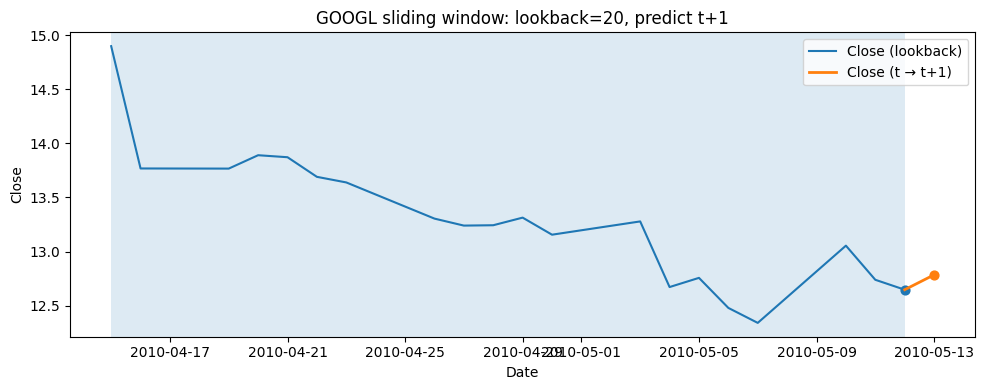

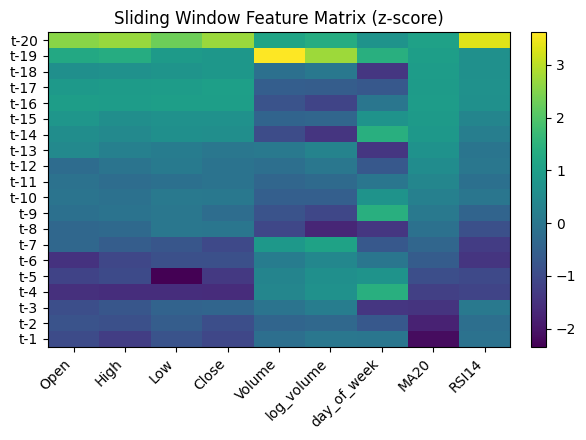

In [4]:
import matplotlib.pyplot as plt
feat = pd.read_parquet(FEAT_PATH)
g = feat[feat["symbol"] == "GOOGL"].sort_values("date").reset_index(drop=True)

end_idx = min(max(LOOKBACK + 50, LOOKBACK + 1), len(g) - 1)
start_idx = end_idx - LOOKBACK
seg = g.iloc[start_idx:end_idx+1].copy()
x_dates = pd.to_datetime(seg["date"])

plt.figure(figsize=(10,4))
plt.plot(x_dates[:-1], seg["Close"].iloc[:-1].values, linewidth=1.5, label="Close (lookback)")
plt.plot(x_dates.iloc[-2:], seg["Close"].iloc[-2:].values, linewidth=2.0, label="Close (t → t+1)")
plt.axvspan(x_dates.iloc[0], x_dates.iloc[-2], alpha=0.15)
plt.scatter(x_dates.iloc[-2], seg["Close"].iloc[-2], s=40)
plt.scatter(x_dates.iloc[-1], seg["Close"].iloc[-1], s=40)
plt.title(f"GOOGL sliding window: lookback={LOOKBACK}, predict t+1")
plt.xlabel("Date"); plt.ylabel("Close"); plt.legend(); plt.tight_layout(); plt.show()

W = g.iloc[start_idx:end_idx][PERDAY].to_numpy()
Wn = (W - W.mean(axis=0, keepdims=True)) / (W.std(axis=0, keepdims=True) + 1e-9)

plt.figure(figsize=(max(6, 0.5*len(PERDAY)), 4.5))
plt.imshow(Wn, aspect="auto", interpolation="nearest")
plt.colorbar(fraction=0.046, pad=0.04)
plt.yticks(range(LOOKBACK), [f"t-{LOOKBACK - i}" for i in range(LOOKBACK)])
plt.xticks(range(len(PERDAY)), PERDAY, rotation=45, ha="right")
plt.title("Sliding Window Feature Matrix (z-score)")
plt.tight_layout(); plt.show()


Step 4 — Sequence Construction and Data Splits

This step converts each stock’s feature history into 3D sequences of shape (samples, lookback, features). Sequences are split chronologically into training, validation, and test sets, ensuring no overlap or leakage across time. All sequences and metadata are saved for later use.

In [5]:
feat = pd.read_parquet(FEAT_PATH)

def build_seq_for_symbol(gdf, lookback):
    gdf = gdf.sort_values("date").reset_index(drop=True)
    X_list, y_list, meta = [], [], []
    vals = gdf[PERDAY].to_numpy()
    yv   = gdf[TARGET_NAME].to_numpy()
    dates = gdf["date"].to_numpy()
    closes = gdf["Close"].to_numpy()
    sym = gdf["symbol"].iloc[0]
    for i in range(lookback, len(gdf)-1):
        X_list.append(vals[i-lookback:i, :])
        y_list.append(yv[i])
        meta.append((dates[i], closes[i-1], closes[i], sym))
    if not X_list:
        return None
    X = np.stack(X_list, axis=0)
    y = np.asarray(y_list)
    meta_df = pd.DataFrame(meta, columns=["date","close_t","close_t+1_actual","symbol"])
    return X, y, meta_df

Xtr_list, ytr_list, mtr_list = [], [], []
Xva_list, yva_list, mva_list = [], [], []
Xte_list, yte_list, mte_list = [], [], []

for sym, g in feat.groupby("symbol"):
    out = build_seq_for_symbol(g, LOOKBACK)
    if out is None:
        continue
    X_all, y_all, meta_all = out
    n = len(meta_all)
    n_train = int(n * TRAIN_FRAC)
    n_val   = int(n_train * VAL_FRAC_WITHIN_T)
    tr0, tr1 = 0, n_train - n_val
    va0, va1 = tr1, n_train
    te0, te1 = n_train, n
    Xtr_list.append(X_all[tr0:tr1]); ytr_list.append(y_all[tr0:tr1]); mtr_list.append(meta_all.iloc[tr0:tr1].assign(split="train"))
    Xva_list.append(X_all[va0:va1]); yva_list.append(y_all[va0:va1]); mva_list.append(meta_all.iloc[va0:va1].assign(split="val"))
    Xte_list.append(X_all[te0:te1]); yte_list.append(y_all[te0:te1]); mte_list.append(meta_all.iloc[te0:te1].assign(split="test"))

def _stack3(X_list, y_list, m_list, f):
    if X_list:
        X = np.concatenate(X_list, axis=0)
        y = np.concatenate(y_list, axis=0)
        m = pd.concat(m_list, ignore_index=True)
    else:
        X = np.empty((0, LOOKBACK, f)); y = np.empty((0,)); m = pd.DataFrame(columns=["date","close_t","close_t+1_actual","symbol","split"])
    return X, y, m

X_tr, y_tr, meta_tr = _stack3(Xtr_list, ytr_list, mtr_list, len(PERDAY))
X_va, y_va, meta_va = _stack3(Xva_list, yva_list, mva_list, len(PERDAY))
X_te, y_te, meta_te = _stack3(Xte_list, yte_list, mte_list, len(PERDAY))

meta_all = pd.concat([meta_tr, meta_va, meta_te], ignore_index=True)
meta_all.to_parquet(WIN_META, index=False)

np.save(ARTIFACTS / "X_train_lstm.npy", X_tr)
np.save(ARTIFACTS / "y_train_lstm.npy", y_tr)
np.save(ARTIFACTS / "X_val_lstm.npy",   X_va)
np.save(ARTIFACTS / "y_val_lstm.npy",   y_va)
np.save(ARTIFACTS / "X_test_lstm.npy",  X_te)
np.save(ARTIFACTS / "y_test_lstm.npy",  y_te)

print("X_tr", X_tr.shape, "X_va", X_va.shape, "X_te", X_te.shape)
print("y_tr", y_tr.shape, "y_va", y_va.shape, "y_te", y_te.shape)
print("meta saved →", WIN_META)


X_tr (182833, 20, 9) X_va (45658, 20, 9) X_te (57173, 20, 9)
y_tr (182833,) y_va (45658,) y_te (57173,)
meta saved → /Users/arvindshine/stock-price-forecasting/LSTM_stock_fresh/data/features/windows_meta.parquet


Step 5 — Feature Scaling

This step applies MinMax scaling feature-wise to stabilise training. The scaler is fit strictly on the training sequences and then applied to validation and test sets to prevent leakage. Scaled arrays are reshaped back into 3D form and saved for downstream modelling.

In [6]:
import joblib
from sklearn.preprocessing import MinMaxScaler

X_tr = np.load(ARTIFACTS / "X_train_lstm.npy")
X_va = np.load(ARTIFACTS / "X_val_lstm.npy")
X_te = np.load(ARTIFACTS / "X_test_lstm.npy")

Ntr,L,F = X_tr.shape
x_scaler = MinMaxScaler()
X_tr_s = x_scaler.fit_transform(X_tr.reshape(Ntr*L, F)).reshape(Ntr, L, F)

Nva = X_va.shape[0]
X_va_s = x_scaler.transform(X_va.reshape(Nva*L, F)).reshape(Nva, L, F)

Nte = X_te.shape[0]
X_te_s = x_scaler.transform(X_te.reshape(Nte*L, F)).reshape(Nte, L, F)

joblib.dump(x_scaler, X_SCALER_PATH)
print("scaled:", X_tr_s.shape, X_va_s.shape, X_te_s.shape)


scaled: (182833, 20, 9) (45658, 20, 9) (57173, 20, 9)


Step 6 — LSTM Model Training

This step defines and trains the LSTM architecture. The model consists of stacked LSTM layers with dropout regularisation and a dense output layer. Training uses the Adam optimiser with mean squared error loss, early stopping to prevent overfitting, and model checkpointing to save the best-performing weights.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

y_tr = np.load(ARTIFACTS / "y_train_lstm.npy")
y_va = np.load(ARTIFACTS / "y_val_lstm.npy")

model = models.Sequential([
    layers.Input(shape=(LOOKBACK, F)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ck = callbacks.ModelCheckpoint(LSTM_PATH, monitor="val_loss", save_best_only=True)

hist = model.fit(
    X_tr_s, y_tr,
    validation_data=(X_va_s, y_va),
    epochs=50,
    batch_size=256,
    callbacks=[es, ck],
    verbose=1
)

print("best val_loss:", np.min(hist.history["val_loss"]))
print("model saved:", LSTM_PATH)


Epoch 1/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 7.9041e-04 - val_loss: 3.0616e-04
Epoch 2/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 3.2007e-04 - val_loss: 3.0518e-04
Epoch 3/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 3.1801e-04 - val_loss: 3.0452e-04
Epoch 4/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 3.0307e-04 - val_loss: 3.0437e-04
Epoch 5/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 3.0052e-04 - val_loss: 3.0551e-04
Epoch 6/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.9907e-04 - val_loss: 3.0459e-04
Epoch 7/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 2.9605e-04 - val_loss: 3.0421e-04
Epoch 8/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.9545e-04 - val_loss: 3.0468e-04
Epoch 9/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.9390e-04 - val_loss: 3.0419e-04
Epoch 10/50
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.9319e-04 - val_loss: 3.0449e-04
Epoch 11/50
715/715 ━━━━━━━━━━━━━━━━━━━

Step 7 — Test Evaluation (Returns)

This step evaluates the trained LSTM on the test split. Metrics such as mean absolute error (MAE) and root mean squared error (RMSE) are reported on next-day returns, providing a direct measure of forecasting accuracy across all stocks in the hold-out period.

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib, numpy as np
import tensorflow as tf

X_te = np.load(ARTIFACTS / "X_test_lstm.npy")
y_te = np.load(ARTIFACTS / "y_test_lstm.npy")

x_scaler = joblib.load(X_SCALER_PATH)
Nte,L,F = X_te.shape
X_te_s = x_scaler.transform(X_te.reshape(Nte*L, F)).reshape(Nte, L, F)

model = tf.keras.models.load_model(LSTM_PATH)
y_hat_te = model.predict(X_te_s, verbose=0).reshape(-1)

def rmse(a,b):
    return np.sqrt(mean_squared_error(a,b))

print("Test MAE (returns):", mean_absolute_error(y_te, y_hat_te))
print("Test RMSE (returns):", rmse(y_te, y_hat_te))


Test MAE (returns): 0.015534200872965946
Test RMSE (returns): 0.024885613196727618


Step 8 — GOOGL-Specific Evaluation

This step isolates GOOGL sequences for focused evaluation. Predicted returns are reconstructed into next-day closing prices to enable comparison with actuals. Metrics are reported on both returns and reconstructed prices (MAE, RMSE, and sMAPE). A plot of actual versus predicted GOOGL prices over the final 250 trading days is also presented.

Figure 2. GOOGL actual vs predicted closing prices
The figure shows actual and predicted GOOGL closing prices over the last 250 trading days of 2021. The predicted series closely overlaps the actual series, confirming the model’s accuracy in capturing short-term dynamics.

GOOGL Return MAE: 0.010978785291734534
GOOGL Return RMSE: 0.01627629848641359
GOOGL Price  MAE: 0.4895511404978598
GOOGL Price  RMSE: 0.8629406320590437
GOOGL Price  sMAPE(%): 1.096921719863948
Saved: /Users/arvindshine/stock-price-forecasting/LSTM_stock_fresh/eval/GOOGL_eval_lstm.csv


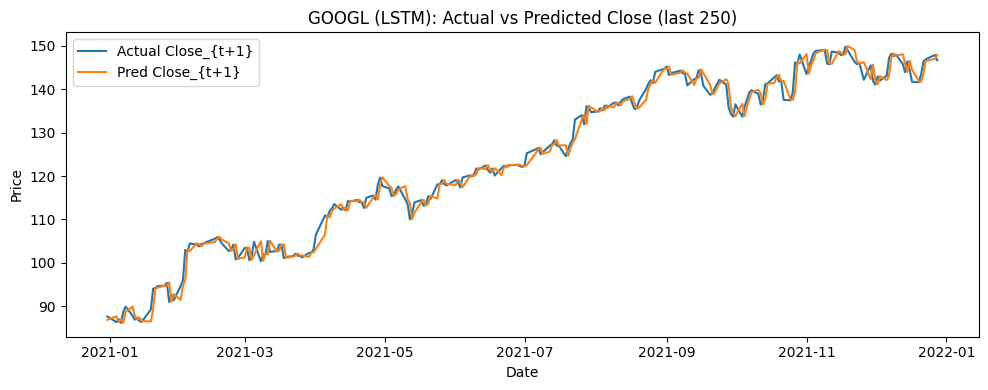

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib, tensorflow as tf

feat = pd.read_parquet(FEAT_PATH)
g = feat[feat["symbol"]=="GOOGL"].sort_values("date").reset_index(drop=True)

def build_seq(df, lookback, perday):
    X_list, y_list, meta = [], [], []
    V = df[perday].to_numpy()
    yv = df[TARGET_NAME].to_numpy()
    dates = df["date"].to_numpy()
    closes = df["Close"].to_numpy()
    for i in range(lookback, len(df)-1):
        X_list.append(V[i-lookback:i, :])
        y_list.append(yv[i])
        meta.append((dates[i], closes[i-1], closes[i]))
    if not X_list:
        return None, None, None
    X = np.stack(X_list, axis=0)
    y = np.asarray(y_list)
    meta_df = pd.DataFrame(meta, columns=["date","close_t","close_t+1_actual"])
    return X, y, meta_df

Xg, yg, meta_g = build_seq(g, LOOKBACK, PERDAY)

x_scaler = joblib.load(X_SCALER_PATH)
Ng,L,F = Xg.shape
Xg_s = x_scaler.transform(Xg.reshape(Ng*L, F)).reshape(Ng, L, F)

model = tf.keras.models.load_model(LSTM_PATH)
yg_hat = model.predict(Xg_s, verbose=0).reshape(-1)

pred_close_next = meta_g["close_t"].to_numpy() * (1.0 + yg_hat)

def rmse(a,b): 
    return np.sqrt(mean_squared_error(a,b))
def smape(a,b):
    a = np.asarray(a); b = np.asarray(b)
    denom = (np.abs(a)+np.abs(b))/2.0
    denom[denom==0] = 1e-9
    return np.mean(np.abs(a-b)/denom)*100

mae_ret  = mean_absolute_error(yg, yg_hat)
rmse_ret = rmse(yg, yg_hat)
mae_px   = mean_absolute_error(meta_g["close_t+1_actual"].to_numpy(), pred_close_next)
rmse_px  = rmse(meta_g["close_t+1_actual"].to_numpy(), pred_close_next)
smape_px = smape(meta_g["close_t+1_actual"].to_numpy(), pred_close_next)

print("GOOGL Return MAE:", mae_ret)
print("GOOGL Return RMSE:", rmse_ret)
print("GOOGL Price  MAE:", mae_px)
print("GOOGL Price  RMSE:", rmse_px)
print("GOOGL Price  sMAPE(%):", smape_px)

EVAL_DIR.mkdir(parents=True, exist_ok=True)
out = pd.DataFrame({
    "date": meta_g["date"],
    "close_t": meta_g["close_t"],
    "close_t+1_actual": meta_g["close_t+1_actual"],
    "pred_ret_t+1": yg_hat,
    "pred_close_t+1": pred_close_next,
})
csv_path = EVAL_DIR / "GOOGL_eval_lstm.csv"
out.to_csv(csv_path, index=False)
print("Saved:", csv_path)

tail = out.tail(250)
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(tail["date"]), tail["close_t+1_actual"], label="Actual Close_{t+1}")
plt.plot(pd.to_datetime(tail["date"]), tail["pred_close_t+1"], label="Pred Close_{t+1}")
plt.title("GOOGL (LSTM): Actual vs Predicted Close (last 250)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()


## Conclusion  

The LSTM experiment demonstrated that a return-based sliding window approach can effectively forecast next-day stock prices when trained on a representative subset of the S&P 500. Using 100 companies over the period 2010–2021, the model achieved strong accuracy on GOOGL evaluation, with MAE ≈ $0.49 and sMAPE ≈ 1.1%.  